In [1]:
import os 
os.chdir(os.path.join(os.getcwd(), '/home/mhill/Projects/BloodSeg-UNETR/')) # '.' if the path is to current folder
print(os.getcwd())



/home/mhill/Projects/BloodSeg-UNETR


In [2]:
from src.unetr_4x4_model import CustomUNETR
import random
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch import nn 

from transformers import ViTModel, ViTConfig

from logs.unetr.view_out import plot_loss, report_metrics, segment
from src.plotters import visualize_predictions
from src.utils import select_device
from src.datasets import UnetCustomDataset, unet_valid_collate
from src.unetr_trainer import UNETR_TRAINER


Change Config Based on model


In [3]:
device = select_device()
vitconfig = { 
    "attention_probs_dropout_prob": 0.0,
    "encoder_stride": 4,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.0,
    "hidden_size": 192,
    "image_size": 64,
    "initializer_range": 0.02,
    "intermediate_size": 768,
    "layer_norm_eps": 1e-06,
    "model_type": "vit",
    "num_attention_heads": 6,
    "num_channels": 16,
    "num_hidden_layers": 6,
    "patch_size": 4,
    "qkv_bias": True,
    "transformers_version": "4.42.3"
    }

unet_config = {
 'BATCH_SIZE': 32,
 'BETA_1': 0.9,
 'BETA_2': 0.95,
 'COMMENT': 'Run 6',
 'FEATURE_SIZE': 32,
 'IN_CHANNEL': 16,
 'LEARNING_RATE': 1e-05,
 'LOG_DIR': 'logs/unetr/6/',
 'NUM_CLASSES': 16,
 'NUM_EPOCHS': 500,
 'RANDOM_SEED': 42,
 'RES_BLOCK': True,
 'SAVE_MODELS': 1,
 'SPATIAL_DIMS': 2,
 'TEST_DATASET': '/home/mhill/Projects/cathepsin/data/unet_testing_dataset.npz',
 'TRAIN_DATASET': '/home/mhill/Projects/cathepsin/data/unet_training_dataset.npz',
 'VALID_DATASET': '/home/mhill/Projects/cathepsin/data/unet_validation_dataset.npz',
 'WEIGHT_DECAY': 0.0
 }
 


MODEL_PATH = "/home/mhill/Projects/cathepsin/logs/unetr/6/model.pth"
checkpoint = torch.load(MODEL_PATH, map_location=device)

encoder = ViTModel(config=ViTConfig(**vitconfig)).to(device)

model = CustomUNETR(encoder=encoder, feature_size=unet_config["FEATURE_SIZE"], num_classes=unet_config["NUM_CLASSES"]).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Loading Test Data

In [4]:
test_data = np.load("/home/mhill/Projects/cathepsin/data/unet_testing_dataset.npz")
test_images, test_labels = test_data['images'], test_data['labels']
test_dataset = UnetCustomDataset(test_images, test_labels)
test_dataloader = DataLoader(
        dataset=test_dataset, 
        batch_size=16, 
        shuffle=False, 
        collate_fn=unet_valid_collate
    )

Train Loss 

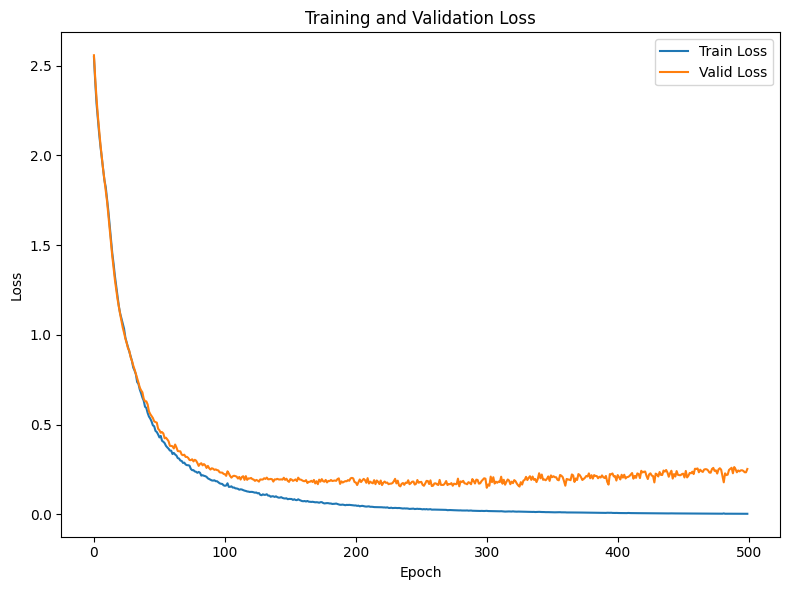

In [5]:
df_train = pd.read_csv("/home/mhill/Projects/cathepsin/logs/unetr/6/training_results.csv")
plot_loss(df_train)

In [6]:
report_metrics(model=model, test_dataloader=test_dataloader)



Test Loss : 0.10786259080824992
{0: 'background', 1: 'white blood cell', 2: 'platelet', 3: 'outer rbc', 4: 'reticulocyte (missing)', 5: 'inner rbc', 6: 'beads', 7: 'monster bead', 8: 'sensor scratch', 9: 'chambertop scratch', 10: 'debris', 11: 'bubble'}


 Class Report : 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      6960
           1       0.95      0.95      0.95       940
           2       0.90      0.87      0.89       135
           3       0.93      0.97      0.95       737
           5       0.94      0.78      0.85       155
           6       0.95      0.92      0.93        62
           7       0.00      0.00      0.00         0
           8       0.75      0.95      0.84       131
           9       0.86      0.87      0.87       132
          10       1.00      0.99      0.99      6360
          11       1.00      1.00      1.00      3211

    accuracy                           0.98     18823
   macro avg       0.8

Shape of image_np : (16, 16, 64, 64) | Label_np : (16, 64, 64) | Predictions : (16, 64, 64)


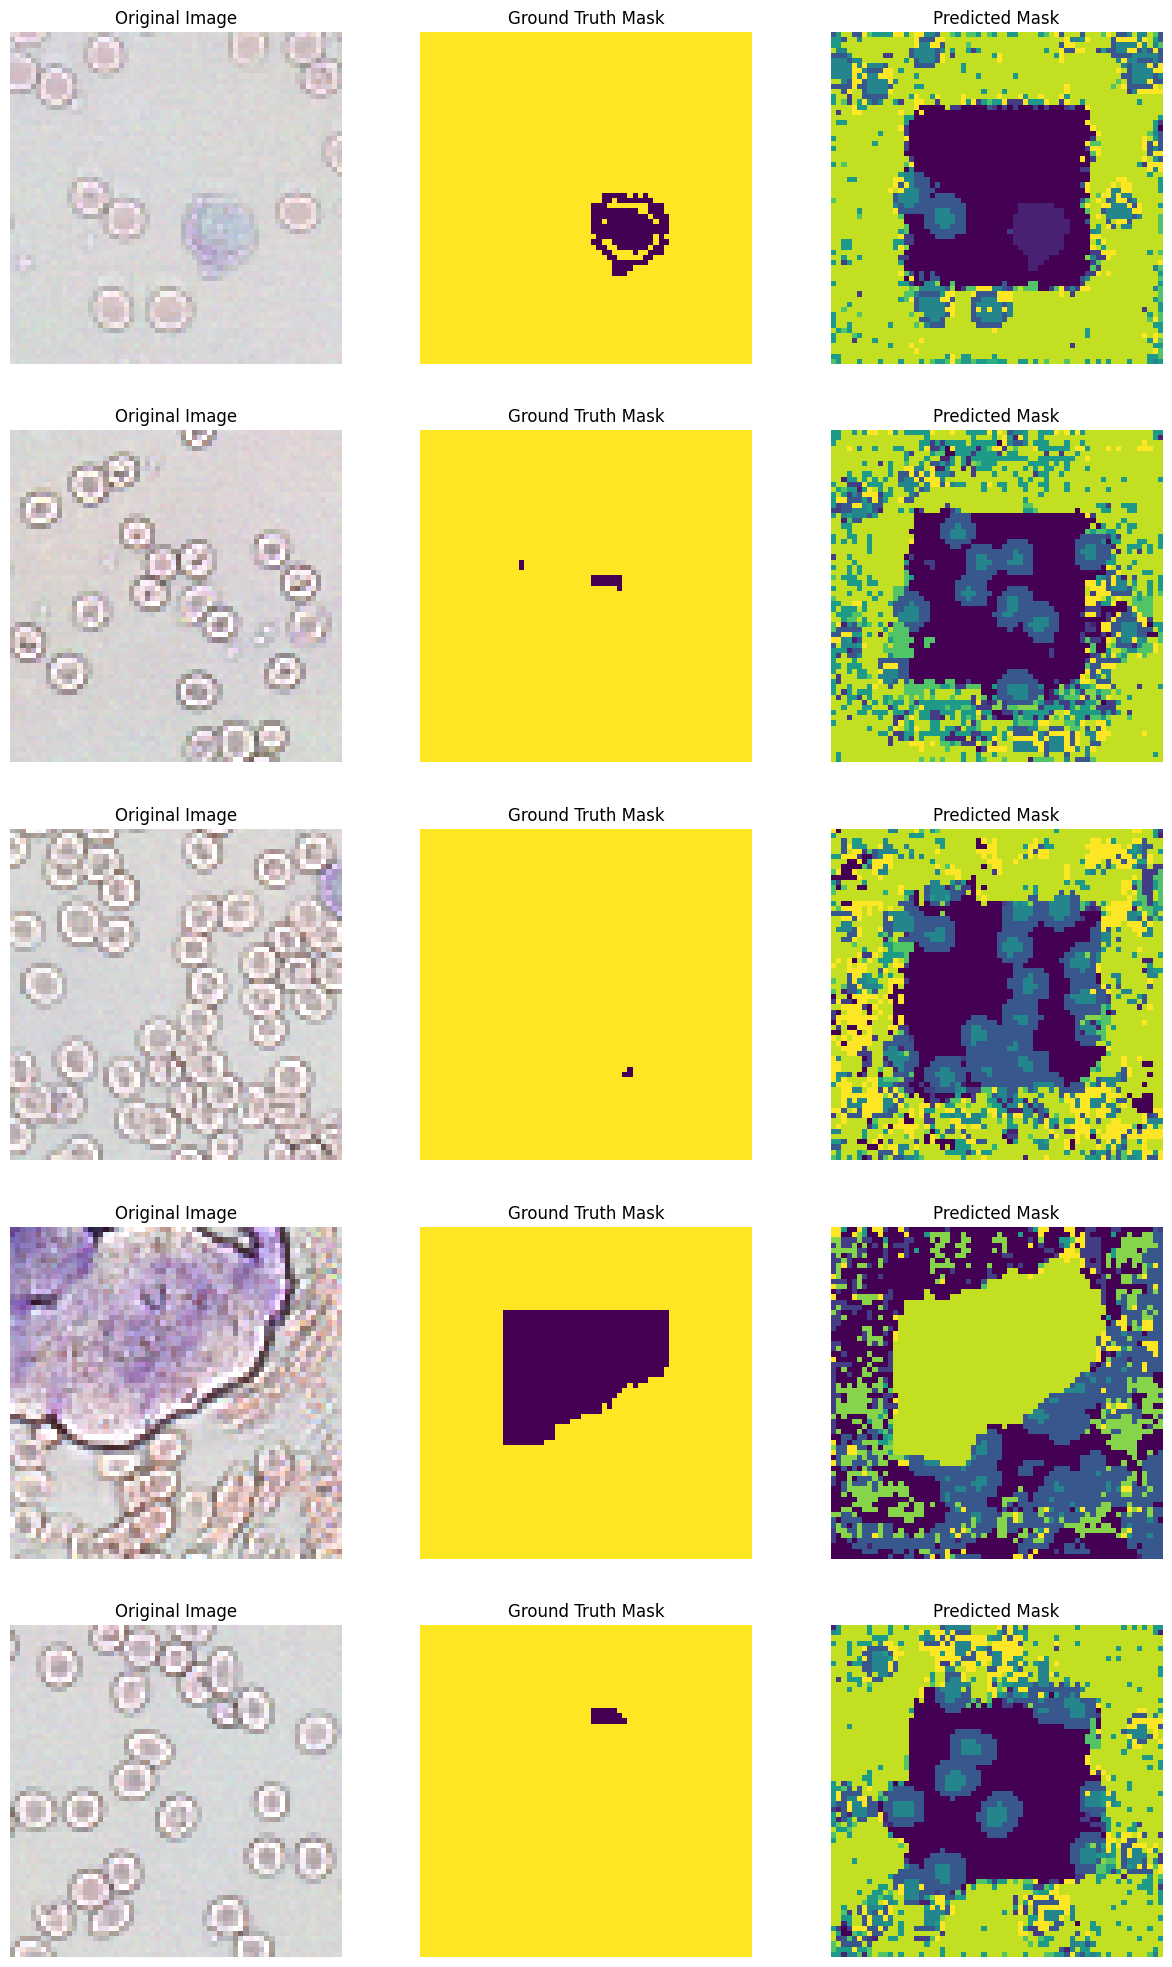

In [7]:
segment(model = model, test_dataloader=test_dataloader)